In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def to_tensor(array):
    array = tf.convert_to_tensor(array, dtype=tf.float32)
    return array

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### 1)Linear Classifier

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape)

K = len(np.unique(y_train)) # Number of Classes
print('Number of classes: ',K)

Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10, 32x32x3=3072

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train:  (50000, 32, 32, 3)
Number of classes:  10


In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

#centering the data and making range similar in order to get stable gradients
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

#re-classify the y(label) sets as categorical: onehot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

#resize x set into a collection of rows, each row is an image
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

y_train: (50000, 10)
y_test: (10000, 10)
x_train: (50000, 3072)
x_test: (10000, 3072)


In [6]:
# tensor conversion

x_test = to_tensor(x_test)
y_test = to_tensor(y_test)

In [16]:
std=1e-5
w1 = to_tensor(std*np.random.randn(Din, K))
b1 = to_tensor(np.zeros(K))
print("w1:", w1.shape)
print("b1:", b1.shape)

batch_size = Ntr    #set batchsize to entire trainingset size
iterations = 300
lr = 0.015         #learning rate
lr_decay= 0.9994   #learning rate decay
reg = 1e-7         #regularization parameter
loss_history = []
train_acc_history = []
val_acc_history = []

#fix seed for random number generator
seed = 0
rng = np.random.default_rng(seed=seed)

w1: (3072, 10)
b1: (10,)


In [17]:
loss_history = []
train_acc_history = []
val_acc_history = []
seed = 0
rng = np.random.default_rng(seed=seed)

t0 = time.time()
for t in range(iterations+1):
    batch_indices = np.random.choice(Ntr,batch_size)
    rng.shuffle(batch_indices)
    x = x_train[batch_indices]
    y = y_train[batch_indices]

    x = to_tensor(x)
    y = to_tensor(y)

    # Forward pass
    y_pred = tf.matmul(x,w1) + b1
    loss = tf.math.reduce_sum( (1./batch_size)* (y_pred-y)**2 ).numpy()  + reg*( tf.math.reduce_sum(tf.math.square(w1)).numpy() )#mean square loss
    loss_history.append(loss)
    
    if t%10 == 0:
        print('epoch %d/%d: mean square loss= %f' % (t,iterations,loss))
    
    dy_pred = to_tensor( (1./batch_size)*2.0*(y_pred-y) )
    dw1 = tf.matmul(x,dy_pred,transpose_a=True) + tf.multiply(reg,w1)
    db1 = tf.reduce_sum(dy_pred,0)

    # Backward pass
    w1 -= lr*dw1
    b1 -= lr*db1
    lr *= lr_decay

t1 = time.time()
print('time taken = '+str(t1-t0))

epoch 0/300: mean square loss= 1.000013
epoch 10/300: mean square loss= 0.874231
epoch 20/300: mean square loss= 0.839483
epoch 30/300: mean square loss= 0.821145
epoch 40/300: mean square loss= 0.810132
epoch 50/300: mean square loss= 0.804604
epoch 60/300: mean square loss= 0.798087
epoch 70/300: mean square loss= 0.796724
epoch 80/300: mean square loss= 0.794776
epoch 90/300: mean square loss= 0.794135
epoch 100/300: mean square loss= 0.791612
epoch 110/300: mean square loss= 0.789110
epoch 120/300: mean square loss= 0.790213
epoch 130/300: mean square loss= 0.790287
epoch 140/300: mean square loss= 0.789881
epoch 150/300: mean square loss= 0.787088
epoch 160/300: mean square loss= 0.786984
epoch 170/300: mean square loss= 0.786494
epoch 180/300: mean square loss= 0.785901
epoch 190/300: mean square loss= 0.785426
epoch 200/300: mean square loss= 0.785073
epoch 210/300: mean square loss= 0.786323
epoch 220/300: mean square loss= 0.783972
epoch 230/300: mean square loss= 0.784057
epo

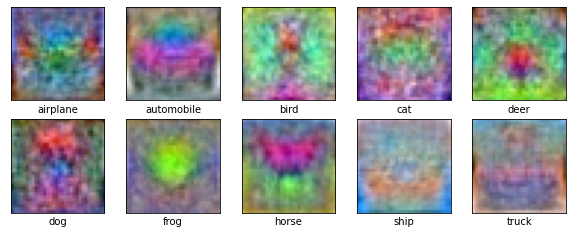

In [18]:
 # W is effectively 10 separate linear classifiers: one classifier per column of W 
 # Displaying w as images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    w = w1[:,i].numpy()
    wnorm = (w-min(w))/max(w) #+ mean_image.reshape(3072)
    wnorm = wnorm/max(wnorm)
    plt.imshow(wnorm.reshape((32,32,3)), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays need the extra index
    plt.xlabel(class_names[i])
plt.show()